<a href="https://colab.research.google.com/github/bflaggs/DSPS_BFlaggs/blob/main/HW10/DSPS2021aenc_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for DSPS2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [3]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd /content/gdrive/Shareddrives/


/content/gdrive/Shareddrives


In [5]:
ls

 DSPS2021/  'IceCube Group Meetings'/


In [6]:
cd  DSPS2021/

/content/gdrive/Shareddrives/DSPS2021


# 1A  (661) load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [7]:
!ls data/faces95/*jpg

data/faces95/adhast.10.jpg  data/faces95/llambr.10.jpg
data/faces95/adhast.11.jpg  data/faces95/llambr.11.jpg
data/faces95/adhast.12.jpg  data/faces95/llambr.12.jpg
data/faces95/adhast.13.jpg  data/faces95/llambr.13.jpg
data/faces95/adhast.14.jpg  data/faces95/llambr.14.jpg
data/faces95/adhast.15.jpg  data/faces95/llambr.15.jpg
data/faces95/adhast.16.jpg  data/faces95/llambr.16.jpg
data/faces95/adhast.17.jpg  data/faces95/llambr.17.jpg
data/faces95/adhast.18.jpg  data/faces95/llambr.18.jpg
data/faces95/adhast.19.jpg  data/faces95/llambr.19.jpg
data/faces95/adhast.1.jpg   data/faces95/llambr.1.jpg
data/faces95/adhast.20.jpg  data/faces95/llambr.20.jpg
data/faces95/adhast.2.jpg   data/faces95/llambr.2.jpg
data/faces95/adhast.3.jpg   data/faces95/llambr.3.jpg
data/faces95/adhast.4.jpg   data/faces95/llambr.4.jpg
data/faces95/adhast.5.jpg   data/faces95/llambr.5.jpg
data/faces95/adhast.6.jpg   data/faces95/llambr.6.jpg
data/faces95/adhast.7.jpg   data/faces95/llambr.7.jpg
data/faces95/adha

In [8]:
flist = glob.glob("data/faces95/*jpg")

In [9]:
N = len(flist)
N

1440


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

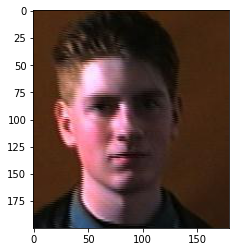

In [10]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

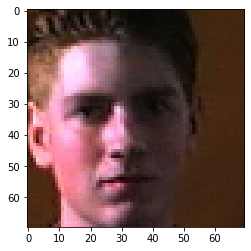

In [11]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'> 461 students - you can skip this and go  straight to loading the images</font>

In [12]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


# 461 studentd - 1B you can read the images below if you have saved them earlier

In [13]:
imgs = np.load("data/faces.npy")
imgs.shape

(1440, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)


In [14]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [15]:
# lower the resolution
# example: take one every N pixels
step=2
'''Not sure what stepsize should be'''
imgs_lr = imgs[:,::step,::step]
# slightly better than the line of code above
#imgs_lr = imgs.reshape(...).mean(...).mean(...)
imgs_lr.shape

(1440, 35, 35, 1)

In [16]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [17]:
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, test_size = .25, random_state=2)

In [18]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 35, 35, 1), (360, 35, 35, 1), (1080, 70, 70, 1), (360, 70, 70, 1))

In [19]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [20]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 1225), (360, 1225), (1080, 4900), (360, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [21]:
img_row=imgs_lr.shape[1]
img_col=imgs_lr.shape[2]
ndim=img_row*img_col
ndim

1225

In [26]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Dense(256, activation="relu", input_dim=img_row*img_col))
model.add(Dense(128, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
'''I think we want our final image to be 70x70 from 35x35 (1225 to 4900) but doing so won't work'''
model.add(Dense(70*70, activation="sigmoid"))






In [27]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               313856    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 56)                7224      
                                                                 
 dense_9 (Dense)             (None, 128)               7296      
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 4900)              1259300   
                                                                 
Total params: 1,653,596
Trainable params: 1,653,596
No

In [28]:
model.compile(optimizer="adadelta", loss="mean_squared_error")

## 4 A train model 

In [29]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), epochs=20, batch_size=100, verbose=1)

Epoch 1/20
11/11 [==============================] - 2s 32ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 2/20
11/11 [==============================] - 0s 11ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 7/20
11/11 [==============================] - 0s 11ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 9/20
11/11 [==============================] - 0s 11ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 10/20
11/11 [==============================] - 0s 11ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 11/

## predict

In [30]:
outim = model.predict(X_te)

In [31]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


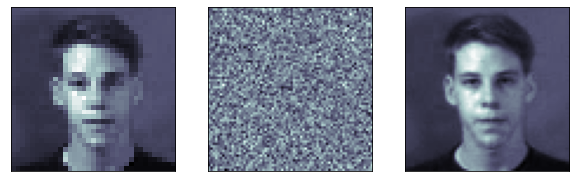

2 :	input		      prediction		  target


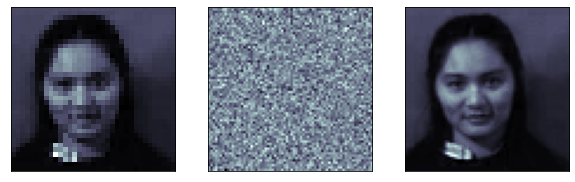

3 :	input		      prediction		  target


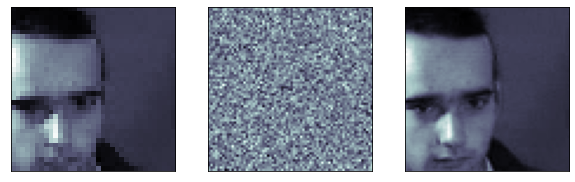

4 :	input		      prediction		  target


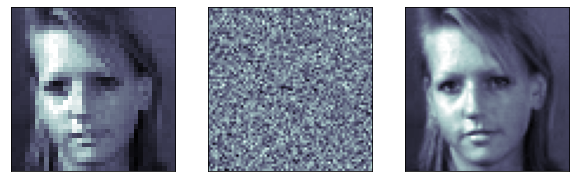

5 :	input		      prediction		  target


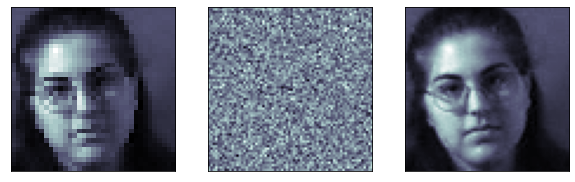

6 :	input		      prediction		  target


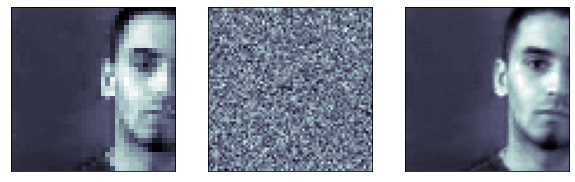

7 :	input		      prediction		  target


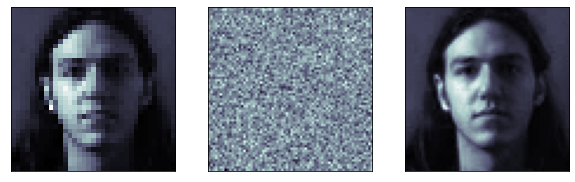

8 :	input		      prediction		  target


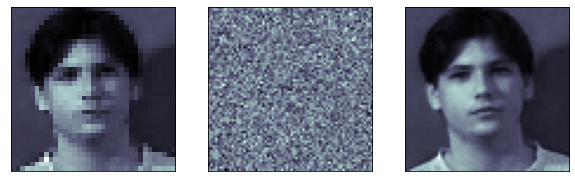

9 :	input		      prediction		  target


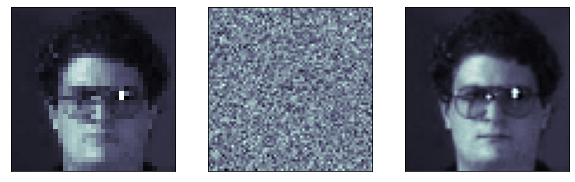

10 :	input		      prediction		  target


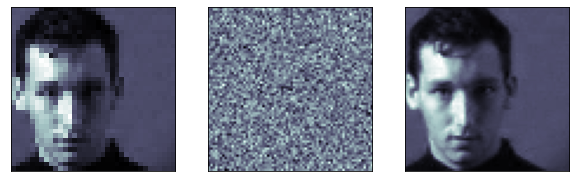

In [34]:
np.random.seed(123)
# pick a few random test images
for i in range(10):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## OPTIONA (EC): show the latent representation of the data: the bottleneck layer output

find a visualization that works for you

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [ ]:
imme = Image.open("data/myimage.png")

low resolution version
subsampling by 15

# is it good? if not why not?